Now we can get more specific with our scrubbing to further clean our dataset. We will create a new DataFrame called pXs (pitch X situation) and reduce our columns to game situational data. As much of the pitches file is individual statistics on the pitch thrown, it would defeat the purpose of attempting to predict a pitch if the data of the pitch was provided.

In [28]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

Reading the csv file created previously from csv_prepare.ipynb

In [29]:
new_1718 = pd.read_csv("new_1718.csv")

In [30]:
pXs = pd.read_csv("pXs.csv", index_col=[0])

In [33]:
# merge the pXs file with new_1718 on pitcher id
pXs = pd.merge(pXs, new_1718, on = 'pitcher_id')

In [35]:
# Drop that has null pitch_type
pXs = pXs.dropna()

In [37]:
# Changing values to numeric
pXs.p_throws = pXs.p_throws.replace(['R', 'L'], [0,1])
pXs.stand = pXs.stand.replace(['R', 'L'], [0,1])
pXs.top = pXs.top.replace([True, False], [1,0])

In [38]:
pXs.pitch_type.value_counts()

FF    254086
SL    122796
FT     81617
CH     74606
CU     60360
SI     57970
FC     39061
KC     16327
FS     10365
KN       719
EP       204
PO        89
FO        84
SC        37
AB         1
Name: pitch_type, dtype: int64

In [39]:
# Deleting pitch types that have low value counts
pXs = pXs[pXs.pitch_type != 'AB']
pXs = pXs[pXs.pitch_type != 'UN']
pXs = pXs[pXs.pitch_type != 'EP']
pXs = pXs[pXs.pitch_type != 'SC']
pXs = pXs[pXs.pitch_type != 'PO']
pXs = pXs[pXs.pitch_type != 'FO']

Combining FF(Four-Seam Fastball) and FT(Two-Seam Fastball) to FB (Fastball); KN and KC(KnuckleCurve) to KN (Knuckleball)

In [40]:
pXs.pitch_type = pXs.pitch_type.replace({"FF": "FB", "FT": "FB", "KC": "KN"})

In [44]:
df = pXs

In [46]:
features = pXs.drop('pitch_type', axis=1)

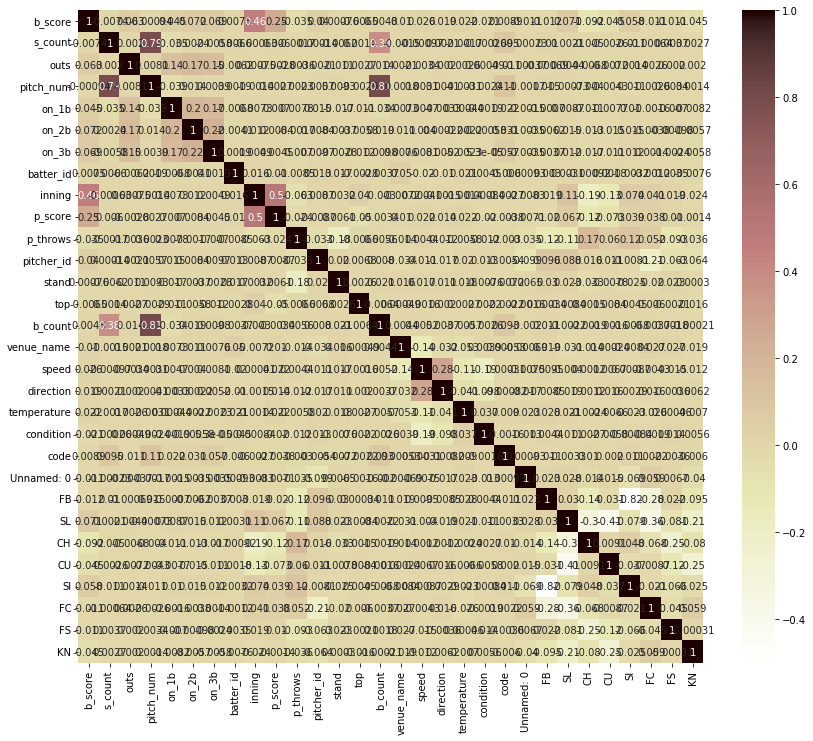

In [47]:
correlation = features.corr() 
plt.figure(figsize=(14,12)) 
heatmap = sns.heatmap(correlation, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

In [48]:
# Drop pitch_num by looking at the correlation heatmap plots 
# pitch_num has strong correlation with b_count, s_count
features = features.drop('pitch_num', axis=1)

In [50]:
# y value = pitch_type
target = df['pitch_type']

In [51]:
example = features

In [52]:
target_e = target

In [53]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score
import xgboost as xgb
import random
from sklearn.model_selection import GridSearchCV

## XGBoost

In [54]:
#splitting the train and test data for the XGB model
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance out of the box
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[  846   120  5202   188     9    84   856   217]
 [  110   602  4345   230    12     4   528   234]
 [  440   359 29299   487   253   195   441  2101]
 [  138    87  1835  1281    15   103   355    66]
 [    4     9   578    10   365     3    21    48]
 [   42     0   880    45    11   530   127    34]
 [  229   142   294   128    13    66  4555   334]
 [   86    50  7808   129    42    20   974  3172]]
              precision    recall  f1-score   support

          CH       0.45      0.11      0.18      7522
          CU       0.44      0.10      0.16      6065
          FB       0.58      0.87      0.70     33575
          FC       0.51      0.33      0.40      3880
          FS       0.51      0.35      0.42      1038
          KN       0.53      0.32      0.40      1669
          SI       0.58      0.79      0.67      5761
          SL       0.51      0.26      0.34     12281

    accuracy                           0.57     71791
   macro avg       0.51      0.39      0.41     7

Finding best parameter in order to enhance the accuracy of the prediction

In [55]:
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#clf.fit(X_train, y_train)
Xgb_train, Xgb_test, yxgb_train, yxgb_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
xgb_param_grid = {"learning_rate": [0.01,0.1,0.3,1],'max_depth': [2,6,10],'min_child_weight': [1,5,10,15],'n_estimators': [50, 100]}
gs = GridSearchCV(clf, xgb_param_grid, n_jobs=1, cv=3)
gs.fit(Xgb_train, yxgb_train)

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lockpick_PC\AppData\Roaming\Python\

C:\Users\lockpick_PC\AppData\Roaming\Python\Python36\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [56]:
gs.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 15,
 'n_estimators': 100}

In [57]:
# put the parameter inside XGBClassifier that u got from gs.best_param
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance with parameters
clf = xgb.XGBClassifier(learning_rate=0.1,max_depth=10,min_child_weight=15,n_estimators=100)
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

[02:02:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[  894    98  5174   198    10    88   830   230]
 [  112   700  4298   210    10     4   513   218]
 [  470   356 29367   512   250   215   391  2014]
 [  138    94  1805  1311    19    99   340    74]
 [    4    13   575    15   358     0    20    53]
 [   43     0   874    46    16   542   123    25]
 [  223   140   294   144    17    66  4544   333]
 [   87    72  7752   132    45    23   937  3233]]
              precision    recall  f1-score   support

          CH       0.45      0.12      0.19      7522
          CU       0.48      0.12      0.19      6065
          FB       0.59      0.87      0.70     33575
          FC       0.51      0.34      0.41      3880
         

Finding best parameter did not result in better accuracy unlike our expectation

In [29]:
# XGBoost with multi:softprob option

In [45]:
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)
print(le.classes_)
# list(le.inverse_transform(target_num)) #If you wish to retrieve the original descriptive labels post production

X_train, X_test, y_train, y_test = train_test_split(example, target_num, \
                                                    test_size=0.1, random_state=77777)

# use DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
fit = xgb.XGBClassifier(eval_metric='mlogloss', objective = 'multi:softprob')
fit.fit(X_train,y_train)
# set xgboost params
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'learning_rate': 0.1,  # the training step for each iteration
    'min_child_weight': 20,
   'n_estimators': 300,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 10}  # the number of classes that exist in this datset
num_rounds=30
#------------- numpy array ------------------
#training and testing - numpy matrices
bst = xgb.train(param, dtrain,num_rounds)
preds = bst.predict(dtest)

#extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array test precision:", precision_score(y_test, best_preds, average='macro'))

['CH' 'CU' 'FB' 'FC' 'FS' 'KN' 'SI' 'SL']


/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:04:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Numpy array test precision: 0.526046322429732


plot that shows the percentage of each pitch type to be thrown for 24th pitch of the data

In [53]:
#creating a dataframe for plotting purposes
plot = pd.DataFrame(data=preds[:,:], columns=['Changeup', 'Curveball', 'Cutter', 'Fastball_4S', \
                          'Splitter', 'Fastball_2S', 'Knucklecurve', 'Knuckleball', 'Sinker', \
                                              'Slider'])

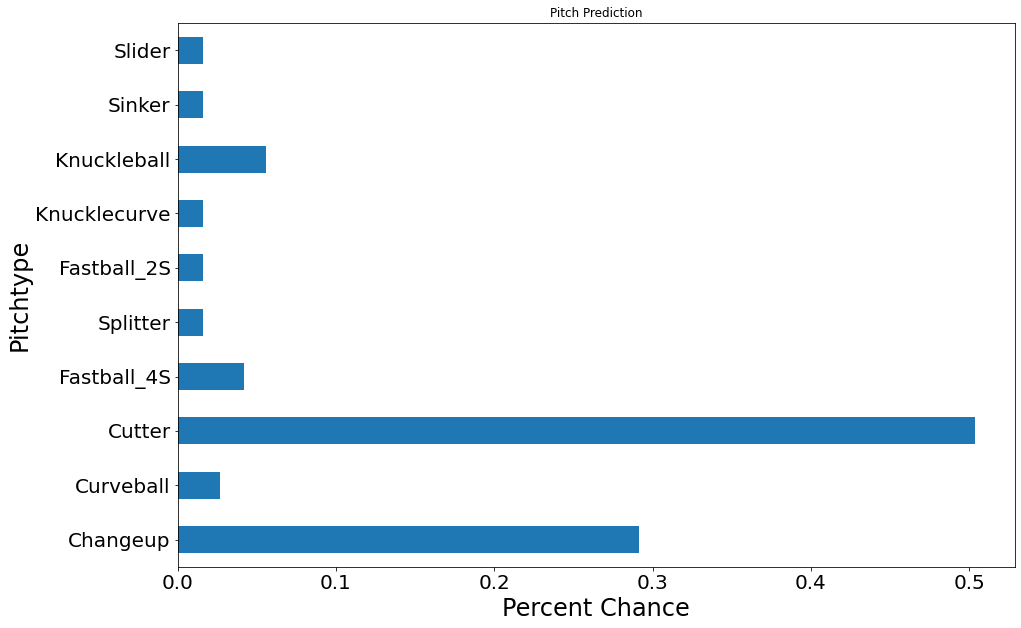

In [54]:
ax = plot.iloc[23].plot(kind='barh',title ="Pitch Prediction", figsize=(15, 10), fontsize=20)
ax.set_xlabel("Percent Chance", fontsize=24)
ax.set_ylabel("Pitchtype", fontsize=24)
plt.show()

## KNN

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_error = []
# Calculating error for K values of 1,4,9,16,25,36,49,64,81
for i in range(1, 10):
    print(i**2)
    knn = KNeighborsClassifier(n_neighbors=i**2)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    test_error.append(np.mean(pred_i != y_test))
a = min(test_error)
for i in range(0,len(test_error)):
    if test_error[i]==a:
        print(i)

1
4
9
16
25
36
49
64
81
6


The result shows that k values of 49 has the smallest test_error

Text(0, 0.5, 'Error Rate')

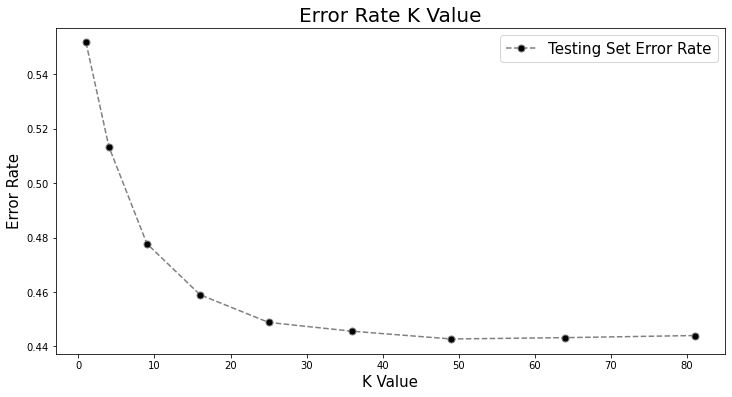

In [30]:
plt.figure(figsize=(12, 6))
plt.plot([1,4,9,16,25,36,49,64,81], test_error, color='grey', linestyle='dashed', marker='o', 
         markerfacecolor='black', markersize=7, label='Testing Set Error Rate')
plt.legend(fontsize = 15)
plt.title('Error Rate K Value', fontsize = 20)
plt.xlabel('K Value', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)

In [27]:
print(a)

0.44274351938265244


In [36]:
# Put the number that you got from KNN to n_neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=49)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=49)

In [37]:
y_pred = classifier.predict(X_test)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,zero_division=True))

[[  582    79  5564   150     2    58   929   158]
 [  109   349  4641   227     8     4   596   131]
 [  330   210 30635   396   150   135   404  1315]
 [  132    64  2059  1134     9    89   343    50]
 [    2     3   740     9   210     2    33    39]
 [   33     0  1011    48     6   434   128     9]
 [  159    90   449   149    11    73  4548   282]
 [   71    30  8860   121    28    25  1032  2114]]
              precision    recall  f1-score   support

          CH       0.41      0.08      0.13      7522
          CU       0.42      0.06      0.10      6065
          FB       0.57      0.91      0.70     33575
          FC       0.51      0.29      0.37      3880
          FS       0.50      0.20      0.29      1038
          KN       0.53      0.26      0.35      1669
          SI       0.57      0.79      0.66      5761
          SL       0.52      0.17      0.26     12281

    accuracy                           0.56     71791
   macro avg       0.50      0.35      0.36     7

In [39]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5572564806173476


## Support Vector Machine

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)

In [ ]:
!pip install daal4py

In [ ]:
from daal4py.sklearn import patch_sklearn
patch_sklearn()

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

## Random Forest

In [42]:
# Changing the target variable to numeric values
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)  

In [43]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(example, target_num, test_size = 0.10, random_state = 77777)

In [44]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 2000, max_depth = 10,
 min_samples_leaf = 12,
 min_samples_split = 16)
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
   
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.5522697831204468
